# PyBaMM show and tell

PyBaMM is an open-source package to simulate physics-based models for lithium-ion batteries using state-of-the-art techniques.  The package is built on Python, and provides a flexible platform for implementation and comparison of new models and numerical methods, and an easy interaction with other Python packages. PyBaMM includes a broad range of standard and cutting-edge models for lithium-ion batteries including electrochemical, thermal and degradation effects.

PyBaMM can easily be installed from Python Package Index (PyPI) with a single line of code in your terminal:

In [1]:
%pip install pybamm

Note: you may need to restart the kernel to use updated packages.


This might take a few minutes and will install PyBaMM and all the necessary dependencies in your computer, no matter if you use Windows, Linux or MacOs.

## Basic example

PyBaMM includes the standard physics-based model for lithium-ion batteries, such as the Doyle-Fuller-Newman (DFN) model, also known as the Newman model or the pseudo-two-dimensional (P2D) model. This model can be solved with a few lines of code:

In [2]:
import pybamm

model = pybamm.lithium_ion.DFN()
sim = pybamm.Simulation(model)
sim.solve([0, 3600])
sim.plot()

interactive(children=(FloatSlider(value=0.0, description='t', max=1.0, step=0.01), Output()), _dom_classes=('w…

## Compare models

PyBaMM also includes other standard models, such as the Single Particle Model (with and without electrolyte). Due to PyBaMM's structure, it is very easy to compare different models.

In [3]:
models = [
    pybamm.lithium_ion.SPM(),
    pybamm.lithium_ion.SPMe(),
    pybamm.lithium_ion.DFN(),
]

sims = []
for model in models:
    sim = pybamm.Simulation(model)
    sim.solve([0, 3600])
    sims.append(sim)
    
pybamm.dynamic_plot(sims)

interactive(children=(FloatSlider(value=0.0, description='t', max=1.0, step=0.01), Output()), _dom_classes=('w…

## Change parameter values

So far we have run the models with the default parameter sets, but PyBaMM includes various parameter sets for different chemistries. It also allows users to define their own parameter sets. For example, to use the parameters for NMC 811 and graphite-SiO$_x$ from Chen et al. (2020), we simply need to add an additional line of code.

In [4]:
model = pybamm.lithium_ion.DFN()
parameter_values = pybamm.ParameterValues("Chen2020")
sim = pybamm.Simulation(model, parameter_values=parameter_values)
sim.solve([0, 3600])
sim.plot()

interactive(children=(FloatSlider(value=0.0, description='t', max=3554.1817016732207, step=35.54181701673221),…

Following open-science principles, PyBaMM provides a list of the references used for the different components of the code (e.g. model, parameters, numerical solvers...). Adding `pybamm.print_citations()` at the end of the script provides a list with all the relevant citations.

In [5]:
pybamm.print_citations()

[1] Joel A. E. Andersson, Joris Gillis, Greg Horn, James B. Rawlings, and Moritz Diehl. CasADi – A software framework for nonlinear optimization and optimal control. Mathematical Programming Computation, 11(1):1–36, 2019. doi:10.1007/s12532-018-0139-4.
[2] Chang-Hui Chen, Ferran Brosa Planella, Kieran O'Regan, Dominika Gastol, W. Dhammika Widanage, and Emma Kendrick. Development of Experimental Techniques for Parameterization of Multi-scale Lithium-ion Battery Models. Journal of The Electrochemical Society, 167(8):080534, 2020. doi:10.1149/1945-7111/ab9050.
[3] Marc Doyle, Thomas F. Fuller, and John Newman. Modeling of galvanostatic charge and discharge of the lithium/polymer/insertion cell. Journal of the Electrochemical society, 140(6):1526–1533, 1993. doi:10.1149/1.2221597.
[4] Charles R. Harris, K. Jarrod Millman, Stéfan J. van der Walt, Ralf Gommers, Pauli Virtanen, David Cournapeau, Eric Wieser, Julian Taylor, Sebastian Berg, Nathaniel J. Smith, and others. Array programming with

For example, in this case we have Andersson et al. (2019) for the CasADI solver, Chen et al. (2020) for the parameter set, or Doyle et al. (1993) for the model.

## Run experiments

So far we have seen constant current discharges, but usually we want to simulate more complex cycles. This can be done using the `Experiment` class. The various steps of the experiment are defined in words and PyBaMM automatically assembles the correct model.

In [6]:
model = pybamm.lithium_ion.DFN()

experiment = pybamm.Experiment(
    [
        ("Discharge at C/10 for 10 hours or until 3.3 V",
        "Rest for 1 hour",
        "Charge at 1 A until 4.1 V",
        "Hold at 4.1 V until 50 mA",
        "Rest for 1 hour"),
    ] * 3
)


sim = pybamm.Simulation(model, experiment=experiment)
sim.solve()
sim.plot()

interactive(children=(FloatSlider(value=0.0, description='t', max=38.90905257874622, step=0.38909052578746217)…

This feature also allows to easily simulate drive cycles from data

In [7]:
import pandas as pd

model = pybamm.lithium_ion.SPMe()

# import drive cycle from file
US06 = pd.read_csv("US06.csv", comment="#", header=None).to_numpy()

experiment = pybamm.Experiment(
    [
        "Run US06 (A) for 5 minutes",
        "Rest for 5 minutes",
        "Run US06 (A) for 10 minutes",
    ],
    drive_cycles={"US06": US06}
)


sim = pybamm.Simulation(model, experiment=experiment)
sim.solve()
sim.plot()

interactive(children=(FloatSlider(value=0.0, description='t', max=1200.0, step=12.0), Output()), _dom_classes=…

## Thermal models

There are a number of thermal submodels available in PyBaMM: at present it includes a lumped thermal model, a 1D thermal model which accounts for the through-cell variation in temperature, and a 2D pouch cell model which assumed the temperature is uniform through the thickness of the pouch, but accounts for variations in temperature in the remaining two dimensions.

### Lumped models
Lumped models calculate the average cell temperature rather than its spatial distribution, but at a very low computational cost.

In [8]:
models = [
    pybamm.lithium_ion.DFN(
        options={"cell geometry": "pouch", "thermal": "lumped"},
        name="Tab cooled",
    ),
    pybamm.lithium_ion.DFN(
        options={"cell geometry": "arbitrary", "thermal": "lumped"},
        name="Surface cooled",
    )
]

sims = []

for model in models:
    sim = pybamm.Simulation(model, C_rate=3)
    sim.solve([0, 1000])
    sims.append(sim)
    
pybamm.dynamic_plot(
    sims, 
    [
        "Volume-averaged cell temperature [K]", 
        "Volume-averaged total heating [W.m-3]", 
        "Current [A]", 
        "Terminal voltage [V]"
    ],
)

interactive(children=(FloatSlider(value=0.0, description='t', max=1000.0, step=10.0), Output()), _dom_classes=…

### 1D (through-cell) model

The 1D model captures temperature variations through the thickness of the cell

In [9]:
model = pybamm.lithium_ion.DFN(options={"thermal": "x-full"})

params = pybamm.ParameterValues("Marquis2019")

params.update({
    "Negative current collector surface heat transfer coefficient [W.m-2.K-1]": 1000,  
    "Positive current collector surface heat transfer coefficient [W.m-2.K-1]": 1000,  
    "Negative tab heat transfer coefficient [W.m-2.K-1]": 200,  
    "Positive tab heat transfer coefficient [W.m-2.K-1]": 200,  
    "Edge heat transfer coefficient [W.m-2.K-1]": 200,
    "Total heat transfer coefficient [W.m-2.K-1]": 200,
})

sim = pybamm.Simulation(model, parameter_values=params, C_rate=5)
sim.solve([0, 1000])
sim.plot(output_variables=[
        "Cell temperature [K]", 
        "Volume-averaged total heating [W.m-3]", 
        "Current [A]", 
        "Terminal voltage [V]"
    ])

interactive(children=(FloatSlider(value=0.0, description='t', max=646.2474546815642, step=6.462474546815643), …

### 2D pouch cell models



In [10]:
# TODO

## Degradation models

PyBaMM allows to add degradation effects on top of the electrochemical (and thermal) models. There are multiple degradation models corresponding to various effects:

* **SEI:** reaction, solvent-diffusion limited, electron-migration limited, interstitial-diffusion limited, and ec reaction limited.
* **Lithium plating:** irreversible and reversible.
* **Mechanics:** particle expansion and cracking.

It is also straightforward to combine multiple mechanisms.


### SEI growth and lithium plating

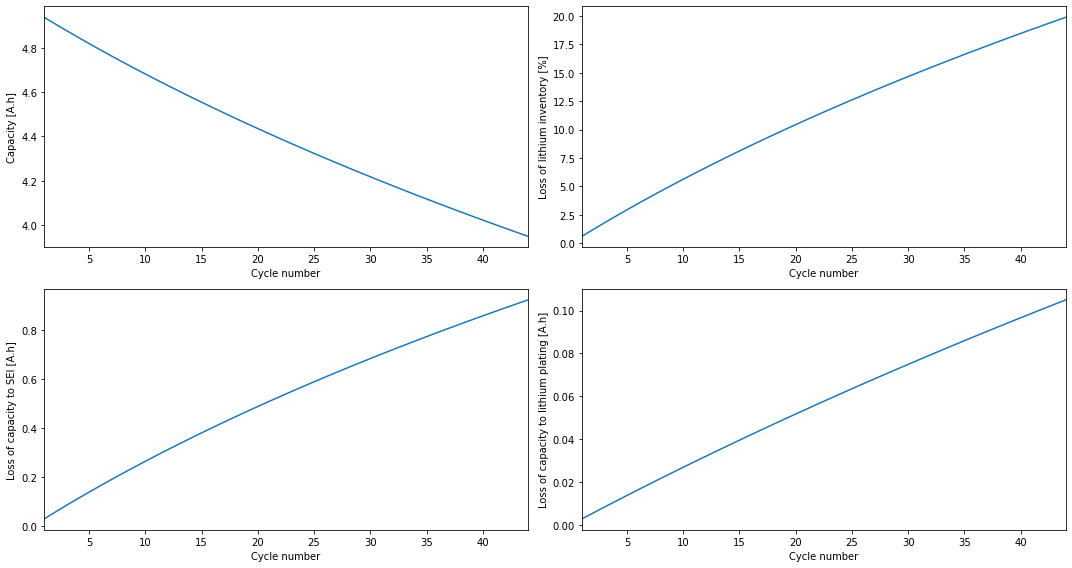

array([[<AxesSubplot:xlabel='Cycle number', ylabel='Capacity [A.h]'>,
        <AxesSubplot:xlabel='Cycle number', ylabel='Loss of lithium inventory [%]'>],
       [<AxesSubplot:xlabel='Cycle number', ylabel='Loss of capacity to SEI [A.h]'>,
        <AxesSubplot:xlabel='Cycle number', ylabel='Loss of capacity to lithium plating [A.h]'>]],
      dtype=object)

In [10]:
model = pybamm.lithium_ion.SPM({"SEI": "ec reaction limited", "lithium plating": "irreversible"})

parameter_values = pybamm.ParameterValues("Mohtat2020")
parameter_values.update({"SEI kinetic rate constant [m.s-1]": 1e-14})

experiment = pybamm.Experiment(
    [("Discharge at 1C until 3 V",
     "Rest for 1 hour",
     "Charge at 1C until 4.2 V", 
     "Hold at 4.2 V until C/50")] * 500,
    termination="80% capacity"
)

sim = pybamm.Simulation(model, experiment=experiment, parameter_values=parameter_values)
sol = sim.solve(initial_soc=1)

pybamm.plot_summary_variables(
    sol, 
    output_variables=["Capacity [A.h]", "Loss of lithium inventory [%]", "Loss of capacity to SEI [A.h]", "Loss of capacity to lithium plating [A.h]"],
    figsize=(15,8)
)

### Cracking and loss of active material

In [11]:
model = pybamm.lithium_ion.DFN(
    options=
    {
        "particle": "Fickian diffusion", 
        "particle mechanics":"swelling and cracking",
        "loss of active material":"stress-driven",
    }
)
param = pybamm.ParameterValues("Ai2020")
param.update({
    "Negative electrode LAM constant proportional term [s-1]": 1e-2/3600,
    "Positive electrode LAM constant proportional term [s-1]": 1e-2/3600,
})

experiment = pybamm.Experiment(
    [
        "Discharge at 1C until 3 V",
        "Rest for 600 seconds",
        "Charge at 1C until 4.2 V",
        "Hold at 4.199 V for 600 seconds",
    ] * 4
)
sim = pybamm.Simulation(model, experiment=experiment, parameter_values=param, solver=pybamm.CasadiSolver("fast with events"))
sim.solve(calc_esoh=False)
sim.plot(output_variables=[
    "X-averaged negative electrode surface area to volume ratio",
    "Negative particle crack length",
    "X-averaged negative particle crack length",
    "Current [A]",
    "X-averaged positive electrode surface area to volume ratio",
    "Positive particle crack length",
    "X-averaged positive particle crack length",
    "Terminal voltage [V]",
])

interactive(children=(FloatSlider(value=0.0, description='t', max=8.979523671748755, step=0.08979523671748754)…

## Particle size distributions


In [12]:
model = pybamm.lithium_ion.DFN(options={"particle size": "distribution"})

params = pybamm.ParameterValues("Marquis2019")
params = pybamm.get_size_distribution_parameters(params)

solver = pybamm.CasadiSolver(mode="fast")
sim = pybamm.Simulation(model, parameter_values=params, solver=solver)

sim.solve(t_eval=[0, 3500])

output_variables = [
    "Negative particle surface concentration distribution",
    "Positive particle surface concentration distribution",
    "X-averaged negative particle surface concentration distribution",
    "Negative area-weighted particle-size distribution",
    "Positive area-weighted particle-size distribution",
    "Terminal voltage [V]",
]

sim.plot(output_variables=[
    "Negative particle surface concentration distribution",
    "Positive particle surface concentration distribution",
    "X-averaged negative particle surface concentration distribution",
    "Negative area-weighted particle-size distribution",
    "Positive area-weighted particle-size distribution",
    "Terminal voltage [V]",
])

interactive(children=(FloatSlider(value=0.0, description='t', max=3500.0, step=35.0), Output()), _dom_classes=…

## liionpack: simulating battery packs

Show a small example of liionpack

In [14]:
%pip install liionpack

  Using cached liionpack-0.3-py3-none-any.whl (28 kB)
  Using cached networkx-2.6.3-py3-none-any.whl (1.9 MB)
  Using cached dask-2022.2.0-py3-none-any.whl (1.1 MB)
  Using cached tqdm-4.64.0-py2.py3-none-any.whl (78 kB)
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement ray (from liionpack) (from versions: none)
ERROR: No matching distribution found for ray


Stepping simulation: 100%|███████████████████████████████████████████████████████████| 631/631 [00:17<00:00, 36.36it/s]


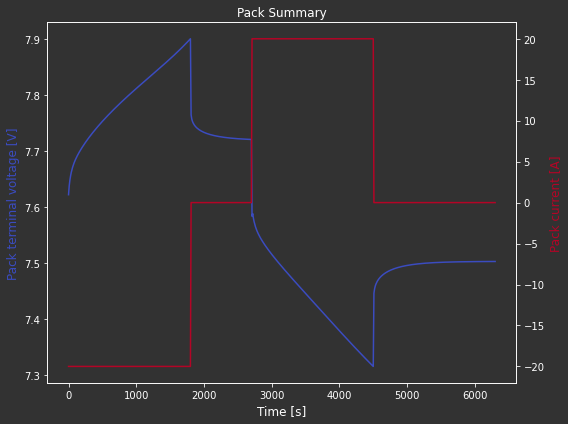

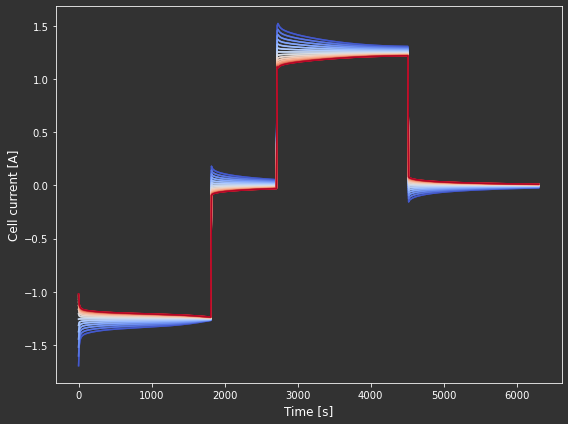

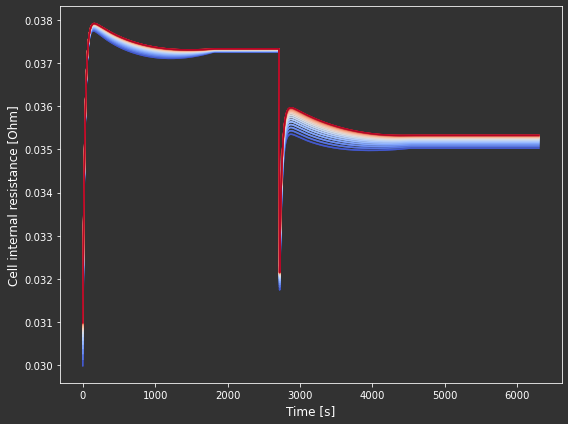

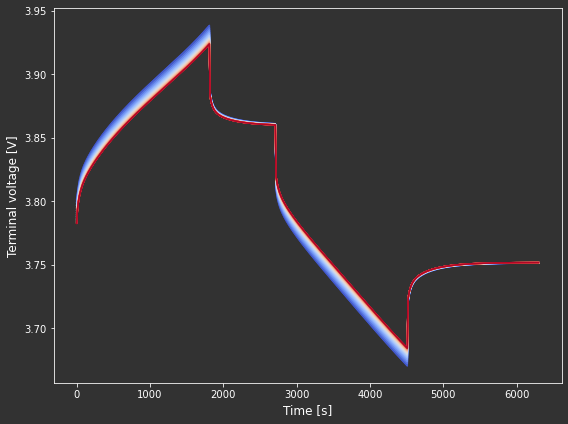

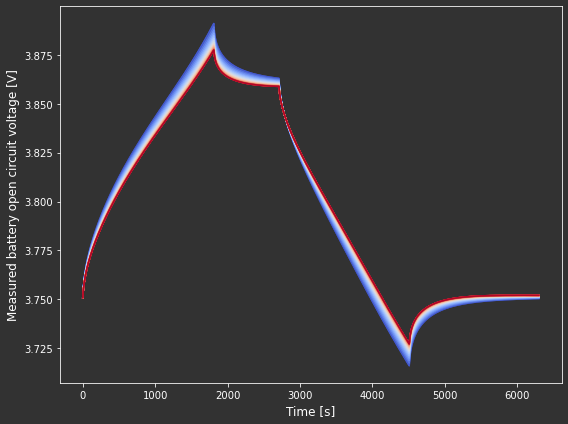

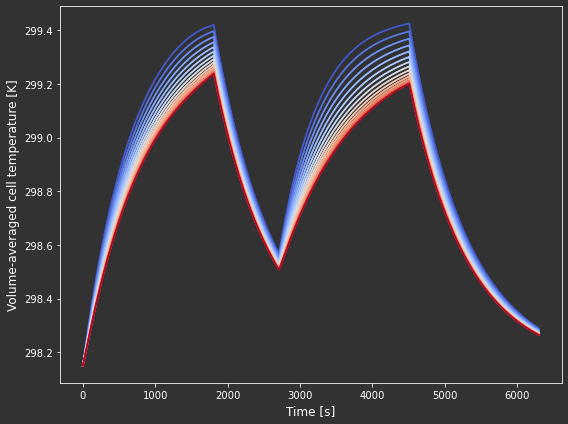

In [14]:
import liionpack as lp
import numpy as np
import os

Np = 16
Ns = 2
# Generate the netlist
netlist = lp.setup_circuit(Np=Np, Ns=Ns)

# Define additional output variables
output_variables = ['Volume-averaged cell temperature [K]']

# Define a cycling experiment using PyBaMM
experiment = pybamm.Experiment([
    'Charge at 20 A for 30 minutes',
    'Rest for 15 minutes',
    'Discharge at 20 A for 30 minutes',
    'Rest for 30 minutes'],
    period='10 seconds')

# Define the PyBaMM parameters
parameter_values = pybamm.ParameterValues(chemistry="Chen2020")
inputs = {"Total heat transfer coefficient [W.m-2.K-1]": np.ones(Np * Ns) * 10}

# Solve the pack
output = lp.solve(netlist=netlist,
                  sim_func=lp.thermal_simulation,
                  parameter_values=parameter_values,
                  experiment=experiment,
                  output_variables=output_variables,
                  initial_soc=0.5,
                  inputs=inputs,
                  nproc=os.cpu_count(),
                  manager='casadi')

# Plot the pack and individual cell results
lp.plot_pack(output)
lp.plot_cells(output)
lp.show_plots()